# Sub-Spider Region

### About this Notebook

This notebook focuses on a large sub-region of the spider. This work looks at using ROHSA's multi-Gaussian decomposition code to model the GHIGLS data. Here, I plot spectra from the cube and analyze the ROHSA model. Also, I plot maps of the data to get a better understanding of what is happening.

_________________________

## Import python libraries

Over this notebook, I will use many different python libraries in my code, so it makes sense to import them here.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA
from scipy.optimize import curve_fit
import random
from scipy.stats import norm

# For the mosaic of the maps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

## Download the cube

In [2]:
# ! wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits

In [3]:
# !pip install ROHSApy

## Load the cube

Now that I have downloaded the data from the GHIGLS website at CITA, I can load the data cube for analysis.

In [4]:
# Now I need to load the data cube that I collected in the above step.
fitsname = "GHIGLS_SPIDER_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[0][:,:,:]
# In the PPV cube, there are 3 axes (Representing the three spaces in the list).
# The first is the velocity axis. The others represent the position coordinates, x and y.

In [5]:
hdr["NAXIS3"] = 175 # The range of subvel (end_subvel - start_subvel)
hdr["CRPIX3"] -= 350 # This is to fix the position of the peaks to have the right index and velocity

In [6]:
def spec_2_velocity(CRVAL, CDELT, CRPIX, index):
    '''
    Description: 
        This function takes in the parameters from the header and adjusts the \
        velocity range so that is centers at zero (based on the reference). 
    
    Parameters:
        CRVAL - The value of the reference velocity - float
        CDELT - The value of the channel spacing - float
        CRPIX - The value of the pixel where CRVAL occurs - float
    
    Returns:
        This function returns the adjusted velocity list - list
    '''
    vel = [(CRVAL + CDELT * (index[i] - CRPIX)) for i in range(len(index))] # Puts in units of km/s
    
    return vel

In [7]:
index_arr = np.arange(cube.shape[0])

cdelt3 = hdr["CDELT3"]/1000. #This allows it to be in units of km/s rather than m/s
crpix3 = hdr["CRPIX3"]
crval3 = hdr["CRVAL3"]/1000. #This allows it to be in units of km/s rather than m/s

vel = np.array(spec_2_velocity(crval3,cdelt3,crpix3,index_arr))

## Functions for producing Gaussians

Here, I define a function for a gaussian function. I will be plotting some gaussians manually, so I need this function for later

In [8]:
# Function for a single Gaussian 
def one_gauss_func(x, amp, cent, sigma):
    '''
    Description: 
        Evaluates a Gaussian function given some parameters
    
    Parameters:
        x - Value at which the Gaussian is evaluated at - float
        amp - The amplitude of the Gaussian - float
        cent - The location of the of the peak - float 
        sigma - The width of the peak - float
    
    Returns:
        The function evaluated at x - float
    '''
    return amp*np.exp(-(x-cent)**2/(2*sigma**2))

## Getting ROHSA for analysis

In this step, I get ROHSA from my supervisor.

In [9]:
!git clone https://github.com/antoinemarchal/ROHSA.git ROHSA
import os
os.chdir('ROHSA/src')
!make
os.chdir('../../')

fatal: destination path 'ROHSA' already exists and is not an empty directory.
gfortran blas.o lbfgsb.o linpack.o timer.o mod_constants.o mod_convert.o mod_inout.o mod_array.o mod_optimize.o mod_optimize_lym.o mod_minimize.o mod_functions.o mod_start.o mod_rohsa.o main.o -lm -g -O2  -o ROHSA


## Define region and set limits

I need to define the region of the Spider I am working with, so I set my ranges in x and y and also in velocity. I am limiting the velocity axis because I only want to focus on the LVC (low velocity cloud) and IVC (intermediate velocity cloud).

In [10]:
idx_lim_left = 350; idx_lim_right = 525

sub_spider_x = 36 ; sub_spider_y = 32

lim = 128
sub_spider_x_left = sub_spider_x ; sub_spider_x_right = sub_spider_x+lim
sub_spider_y_left = sub_spider_y ; sub_spider_y_right = sub_spider_y+lim

idx_lim_left = 350; idx_lim_right = 525

subvel_sub_spider = vel[idx_lim_left:idx_lim_right]
subcube_sub_spider = cube[idx_lim_left:idx_lim_right, sub_spider_y_left:sub_spider_y_right, sub_spider_x_left:sub_spider_x_right] # Want the sub spider, so full x and y axes

In [11]:
fixed_subvel_sub_spider = subvel_sub_spider-subvel_sub_spider[np.argmax(cube[idx_lim_left:idx_lim_right,\
                                                                             sub_spider_y, sub_spider_x])]

Now, we can plot the spectrum of a random point.

In [12]:
# Range of x and y are from 0 to 171
x_rand = random.randint(0,170); y_rand = random.randint(0,171)

In [13]:
# interesting one: x=68, y=109  other good ones: (x=170,y=6), (x=53,y=78), (x=170,y=55)

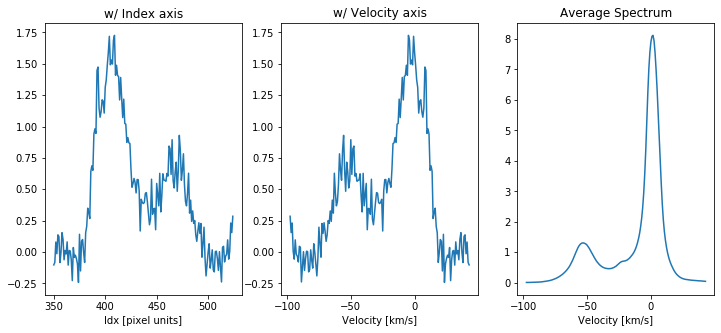

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.title("w/ Index axis"); plt.xlabel("Idx [pixel units]")
plt.plot(index_arr[idx_lim_left:idx_lim_right], cube[idx_lim_left:idx_lim_right,y_rand, x_rand])

plt.subplot(1,3,2)
plt.title("w/ Velocity axis"); plt.xlabel("Velocity [km/s]")
plt.plot(fixed_subvel_sub_spider, cube[idx_lim_left:idx_lim_right,y_rand,x_rand])

plt.subplot(1,3,3)
avg_sub_spider = np.mean(subcube_sub_spider, (1,2))
plt.title("Average Spectrum"); plt.xlabel("Velocity [km/s]")
plt.plot(fixed_subvel_sub_spider, avg_sub_spider)

plt.show()

## Define ROHSA parameters

Now we want to use ROHSA to model the data. Here, I am defining all of the parameters that ROHSA needs. 

In [15]:
filename = "GHIGLS_SPIDER_Tb.dat" #@param
fileout = "GHIGLS_SPIDER_Tb_gauss_run_sub_spider_lambda_100_varsig_150.dat" #@param
filename_parameters = "parameters_sub_spider_lambda_100_varsig_150.txt"
filename_noise = ''
n_gauss = 24         #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 100       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_amp = 0.                                                                                                                                                                                                                                                           
lambda_var_mu = 0.                                                                                                                                                                                                                                                        
lambda_var_sig = 50  #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 800         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
noise = ".false."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 
lb_sig_init = 2.
ub_sig_init = 10.
lb_sig = 2.
ub_sig = 100.

core = ROHSA(subcube_sub_spider, hdr=hdr)            
core.cube2dat(filename=filename)
core.gen_parameters(filename=filename, 
                    fileout=fileout,
                    filename_parameters=filename_parameters,
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    maxiter=maxiter,
                    descent=descent,
                    lstd=lstd,
                    ustd=ustd,
                    iprint=iprint,
                    lb_sig_init=lb_sig_init,
                    ub_sig_init=ub_sig_init,
                    lb_sig = lb_sig,
                    ub_sig = ub_sig,
                    save_grid=save_grid)

Generate GHIGLS_SPIDER_Tb.dat file readable by fortran
Generate parameters_sub_spider_lambda_100_varsig_150.txt file


Now, I can actually run ROHSA with the data using the parameter file just generated.

In [16]:
#! nohup ./ROHSA/src/ROHSA parameters_sub_spider_lambda_100_varsig_150.txt

## Get Gaussian parameters

After ROHSA is finished running, I extract the model. 

In [17]:
# Some constants for the integrals:
dv = abs(cdelt3)
C = 1.82243e18

In [18]:
gaussian_sub_spider = core.read_gaussian("GHIGLS_SPIDER_Tb_gauss_run_sub_spider_lambda_100_varsig_150.dat")
params = core.physical_gaussian(gaussian_sub_spider)

print("dim cube = " + str(gaussian_sub_spider.shape))

model_sub_spider = core.return_result_cube(gaussian=gaussian_sub_spider)

# Physical Space
amplitude_sub_spider = gaussian_sub_spider[0::3]
position_sub_spider = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_sub_spider[1::3]))
dispersion_sub_spider = gaussian_sub_spider[2::3] * dv

# "Pixel" Space
amplitude_pix = gaussian_sub_spider[0::3]
position_pix = gaussian_sub_spider[1::3]
dispersion_pix = gaussian_sub_spider[2::3]* dv

integral_sub_spider = amplitude_sub_spider * dispersion_sub_spider * np.sqrt(2*np.pi) 

Opening data file
dim cube = (72, 128, 128)


In [19]:
NHI_map_sub_spider = integral_sub_spider * C

## Plot a spectrum

In [20]:
def plot_spect(x_pos, y_pos, vel, model, cube, gaussian, caption=""):
    fig = plt.figure(figsize=(8,6))
    plt.xlabel("$v$ [$km$ $s^{-1}$]")
    plt.ylabel("$T_{b}$ [$K$]")
    plt.plot(vel, cube, color='cornflowerblue',  label="data")
    plt.plot(vel, model , color='red', label="model")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
            plt.plot(vel, core.gauss(np.arange(len(vel)), \
                                     gaussian[0::3][i][y_pos,x_pos],\
                                     gaussian[1::3][i][y_pos,x_pos],\
                                     gaussian[2::3][i][y_pos,x_pos]), 'k')
    plt.legend()
    plt.show()
    fig.savefig(caption, bbox_inches="tight")

In [21]:
x_pos_sub_spider = 75; y_pos_sub_spider = 100 #20

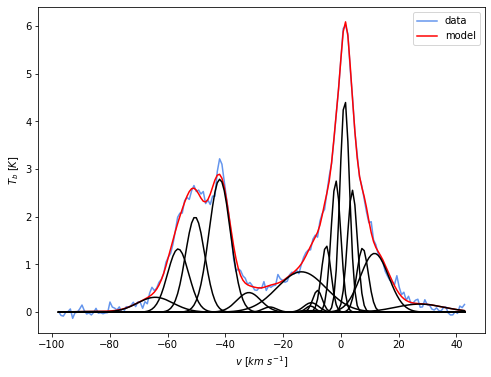

In [22]:
plot_spect(x_pos_sub_spider, y_pos_sub_spider, fixed_subvel_sub_spider,\
           model_sub_spider[:, y_pos_sub_spider, x_pos_sub_spider], \
           subcube_sub_spider[:, y_pos_sub_spider, x_pos_sub_spider], gaussian_sub_spider,\
           "Spectrum_of_random_position.pdf")

## Find value of $\chi^{2}$

This step is important because it tells us how good of a fit the model is to the data. Since we are fitting 24 gaussians (with 72 parameters, 3 per gaussian) and there are 175 points plotted, the ideal value of $\chi^{2}$ would be about 100 (175-72). 

In [23]:
stdev_sub_spider = np.std(cube[5:25,0,0])
stdev_sub_spider

0.124584325

In [24]:
subcube_sub_spider = subcube_sub_spider

N_model_sub_spider = model_sub_spider[:,y_pos_sub_spider, x_pos_sub_spider] # Actual spectrum data
N_data_sub_spider = subcube_sub_spider[:,y_pos_sub_spider, x_pos_sub_spider] # Gaussian model 

r_sub_spider = N_data_sub_spider - N_model_sub_spider

chisq_sub_spider = np.sum((r_sub_spider / stdev_sub_spider)**2)
print("The value of chi squared is:", chisq_sub_spider)

The value of chi squared is: 101.30808954745798


From this, we see that the model is a very good fit to the data.

## Plot a mosaic of spectra

Even better than plotting just one spectrum, we can plot a mosaic of multiple spectra to see how the model and data changes for a different position in the cube.

<Figure size 432x288 with 0 Axes>

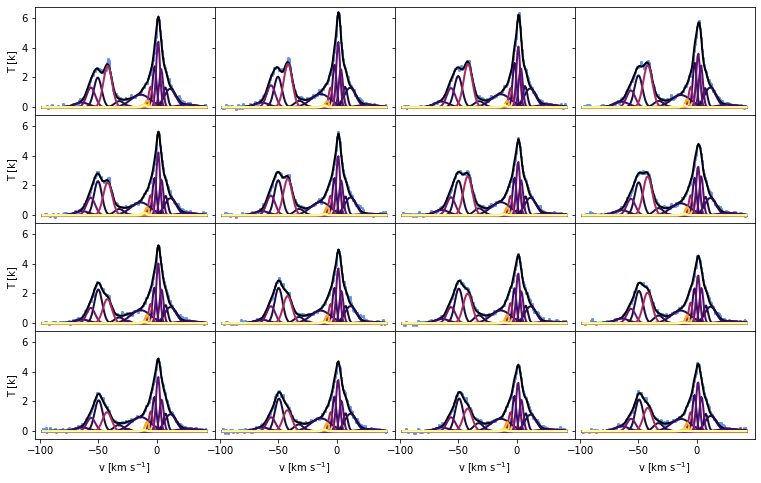

In [25]:
# Mosaic of the Spectra
pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

fig=plt.figure()
ny = 4; nx = 4
center_y = y_pos_sub_spider; center_x = x_pos_sub_spider
cb = "magenta"
cw = "crimson"
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)
for i in np.arange(ny):
    for j in np.arange(nx):
        axs[i][j].step(fixed_subvel_sub_spider, subcube_sub_spider[:,center_y+i,center_x+j], color='cornflowerblue', linewidth=2.)
        axs[i][j].plot(fixed_subvel_sub_spider, model_sub_spider[:,center_y+i,center_x+j], linestyle="-", linewidth=2., color="k")
        for k in range(n_gauss):
            axs[i][j].plot(fixed_subvel_sub_spider, core.gauss(np.arange(len(fixed_subvel_sub_spider)), gaussian_sub_spider[0::3][k][center_y+i,center_x+j],
                                              gaussian_sub_spider[1::3][k][center_y+i,center_x+j], gaussian_sub_spider[2::3][k][center_y+i,center_x+j]),
                           linewidth=2., color=plt.cm.inferno(pvalues[k]))
        if j == 0: axs[i][j].set_ylabel(r'T [k]')
        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
fig.savefig("Mosaic_of_Spectra_sub_spider.pdf", bbox_inches="tight")

## 2D Histogram (Heat map)

Here, it is useful to visualize the gaussians by their parameters (in particular, velocity, $v$ and dispersion, $\sigma$). We can map these two parameters and plot each gaussian in a two-dimensional histogram ("Heat map").

In [26]:
iddx = np.argsort(np.mean(position_sub_spider, axis=(1,2)))
field = [NHI_map_sub_spider[idd] for idd in iddx]
vfield = [position_sub_spider[idd] for idd in iddx]
ampfield = [amplitude_sub_spider[idd] for idd in iddx]
sigfield = [dispersion_sub_spider[idd] for idd in iddx]

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


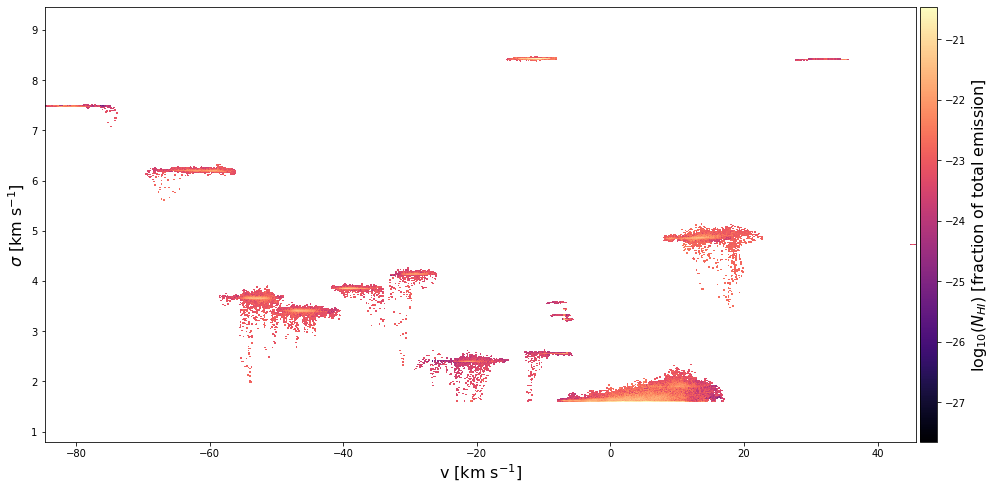

In [27]:
#HEATMAP 
x_bins = np.linspace(np.min(params[1::3].ravel()), np.max(params[1::3].ravel()), 1200)
y_bins = np.linspace(0.8,np.max(dispersion_sub_spider)+1, 1200)
H, xedges, yedges = np.histogram2d(params[1::3].ravel(), params[2::3].ravel(),weights=np.sqrt(2.*np.pi)*params[0::3].ravel()*(params[2::3].ravel())*C/1.e18/np.sum(field),\
                                   bins=[x_bins, y_bins])
#H = np.ma.masked_invalid(np.atleast_2d(H))
fig = plt.figure(figsize=(16.,8.))
ax = fig.add_subplot(111)
ax.set_ylim([0.8, np.max(dispersion_sub_spider)+1])
ax.set_xlim([np.min(params[1::3].ravel()),np.max(params[1::3].ravel())])
ax.set_xlabel(r'v [km s$^{-1}$]',  fontsize = 16)
ax.set_ylabel(r'$\sigma$ [km s$^{-1}$]',  fontsize = 16)
ax.yaxis.set_major_formatter(ScalarFormatter())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
im = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap="magma")
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label(r'log$_{10}$($N_{HI}$) [fraction of total emission]', fontsize = 16)
fig.savefig("2D_Histogram_heat_map_sub_spider_lambda_100_30gauss.pdf", bbox_inches="tight")
#plt.savefig("plot/" + 'heatmap.png', format='png', bbox_inches='tight', pad_inches=0.02)

We define some regions based on the clusters. 

LVC is from about -16km/s to 40km/s and IVC is from -20km/s to -100km/s. Looking at the dispersion, we define the CNM (cold neutral medium) to have disperion of 3 or less. UNM (unstable/lukewarm neutral medium) ranges from dispersion of 3-6. Finally, WNM (warm neutral medium) has dispersion of 6+.

Here, I can take a small cluster on the histogram and plot a map to get a better idea of what is going on. Some interesting features include the clouds and also the "rain" coming down from the clouds, which hint at the transition from UNM or WNM to CNM.

In [28]:
lower_lim_vel = -20. ; upper_lim_vel = 0.
lower_lim_disp = 8. ; upper_lim_disp = 9.

for i in range(subcube_sub_spider.shape[1]):
    for j in range(subcube_sub_spider.shape[2]):
        
        Column_Density_map_cluster = np.zeros((subcube_sub_spider.shape[1], subcube_sub_spider.shape[2]))
        
        for n in range(n_gauss):
            # Velocity limit
            if (position_sub_spider[n][i][j] < upper_lim_vel) and (position_sub_spider[n][i][j] > lower_lim_vel):
                # Dispersion limit
                if (dispersion_sub_spider[n][i][j] < upper_lim_disp) and (dispersion_sub_spider[n][i][j] > lower_lim_disp):
                    
                    Column_Density_map_cluster = Column_Density_map_cluster + integral_sub_spider[n]

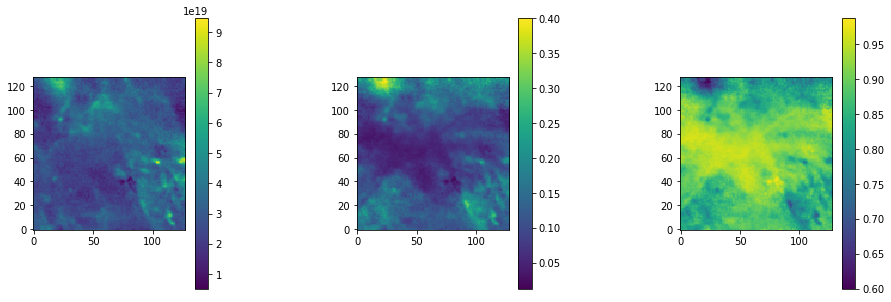

In [29]:
fig = plt.figure(figsize=(15,5))
sum_map = np.sum(NHI_map_sub_spider, 0)

plt.subplot(1,3,1)
plt.imshow(Column_Density_map_cluster * C, origin="lower")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow((Column_Density_map_cluster * C) / sum_map , origin="lower")
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow((sum_map - Column_Density_map_cluster * C) / sum_map, origin="lower")
plt.colorbar()
plt.subplots_adjust(wspace=0.7); plt.show()

## Column Density maps of LVC and IVC

Iterate over every pixel to separate CNM, UNM and WNM and then create the PPV cubes for each of these for the LVC and IVC regions. Within the LVC and IVC, there are CNM (low dispersion), UNM (intermediate dispersion) and WNM (large dispersion). I define ranges for each of these and sum them into their own individual data cube.

In [30]:
model_LVC_CNM = np.zeros(subcube_sub_spider.shape)
model_LVC_UNM = np.zeros(subcube_sub_spider.shape)
model_LVC_WNM = np.zeros(subcube_sub_spider.shape)

model_IVC_CNM = np.zeros(subcube_sub_spider.shape)
model_IVC_UNM = np.zeros(subcube_sub_spider.shape)
model_IVC_WNM = np.zeros(subcube_sub_spider.shape)

for i in range(subcube_sub_spider.shape[1]):
    for j in range(subcube_sub_spider.shape[2]):  # Iterate over every pixel to look at each gaussian individually
        for n in range(n_gauss):

            # LVC CNM
            if position_sub_spider[n][i][j] > -15. and dispersion_sub_spider[n][i][j] < 3.:
                spectrum_LVC_CNM = one_gauss_func(np.arange(subcube_sub_spider.shape[0]), amplitude_pix[n][i][j], \
                                              position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                model_LVC_CNM[:, i, j] += spectrum_LVC_CNM
              
            # LVC UNM
            if position_sub_spider[n][i][j] > -15. and dispersion_sub_spider[n][i][j] >= 3. and dispersion_sub_spider[n][i][j] < 6.:
                spectrum_LVC_UNM = one_gauss_func(np.arange(subcube_sub_spider.shape[0]), amplitude_pix[n][i][j], \
                                              position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                model_LVC_UNM[:, i, j] += spectrum_LVC_UNM
            
            # LVC WNM
            if position_sub_spider[n][i][j] > -20. and dispersion_sub_spider[n][i][j] >= 6.:
                spectrum_LVC_WNM = one_gauss_func(np.arange(subcube_sub_spider.shape[0]), amplitude_pix[n][i][j], \
                                              position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                model_LVC_WNM[:, i, j] += spectrum_LVC_WNM
                
            # IVC CNM
            if position_sub_spider[n][i][j] < -15. and dispersion_sub_spider[n][i][j] < 3.:
                spectrum_IVC_CNM = one_gauss_func(np.arange(subcube_sub_spider.shape[0]), amplitude_pix[n][i][j], \
                                              position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                model_IVC_CNM[:, i, j] += spectrum_IVC_CNM
              
            # IVC UNM
            if position_sub_spider[n][i][j] < -15. and dispersion_sub_spider[n][i][j] >= 3. and dispersion_sub_spider[n][i][j] < 6.:
                spectrum_IVC_UNM = one_gauss_func(np.arange(subcube_sub_spider.shape[0]), amplitude_pix[n][i][j], \
                                              position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                model_IVC_UNM[:, i, j] += spectrum_IVC_UNM
            
            # IVC WNM
            if position_sub_spider[n][i][j] < -20. and dispersion_sub_spider[n][i][j] >= 6.:
                spectrum_IVC_WNM = one_gauss_func(np.arange(subcube_sub_spider.shape[0]), amplitude_pix[n][i][j], \
                                              position_pix[n][i][j], dispersion_pix[n][i][j]/dv)
                model_IVC_WNM[:, i, j] += spectrum_IVC_WNM

Now that I have each of the data cubes, I can plot a column density map of the cubes at each section of the LVC and IVC.

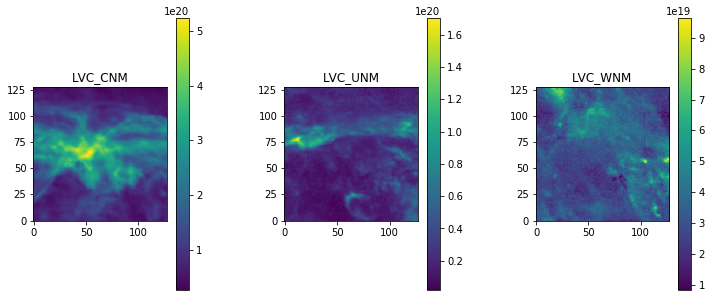

In [31]:
# Plot of the LVC maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,3,1) ; plt.title("LVC_CNM")
plt.imshow(np.sum(model_LVC_CNM * C * dv, 0), origin="lower") ; plt.colorbar()
plt.subplot(1,3,2) ; plt.title("LVC_UNM")
plt.imshow(np.sum(model_LVC_UNM * C * dv, 0), origin="lower") ; plt.colorbar()
plt.subplot(1,3,3) ; plt.title("LVC_WNM")
plt.imshow(np.sum(model_LVC_WNM * C * dv, 0), origin="lower") ; plt.colorbar()
plt.subplots_adjust(wspace=0.5)
fig.savefig("Column_Density_maps_of_LVC.pdf", bbox_inches='tight')

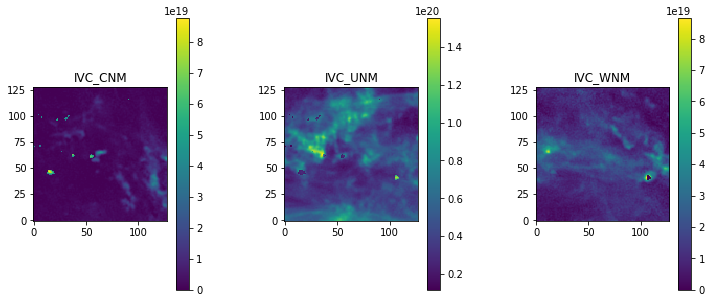

In [32]:
# Plot of the IVC maps (CNM, UNM and WNM)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,3,1) ; plt.title("IVC_CNM")
plt.imshow(np.sum(model_IVC_CNM * C * dv, 0), origin="lower") ; plt.colorbar()
plt.subplot(1,3,2) ; plt.title("IVC_UNM")
plt.imshow(np.sum(model_IVC_UNM * C * dv, 0), origin="lower") ; plt.colorbar()
plt.subplot(1,3,3) ; plt.title("IVC_WNM")
plt.imshow(np.sum(model_IVC_WNM * C * dv, 0), origin="lower") ; plt.colorbar()
plt.subplots_adjust(wspace=0.5)
fig.savefig("Column_Density_maps_of_IVC.pdf", bbox_inches='tight')

Also, I can plot a single spectrum and plot one of the above models against the original data to see just how the models are separate.

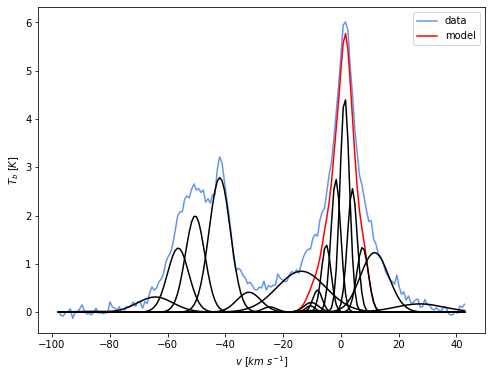

In [33]:
plot_spect(x_pos_sub_spider, y_pos_sub_spider, fixed_subvel_sub_spider,\
           model_LVC_CNM[:, y_pos_sub_spider, x_pos_sub_spider], \
           subcube_sub_spider[:, y_pos_sub_spider, x_pos_sub_spider], gaussian_sub_spider, \
           "Spectrum_of_model_LVC_CNM.pdf")

Notice how here, since I am plotting the model corresponding the LVC_CNM, the model (red) is only representing the Gaussian functions in the LVC and that are CNM.

## Plot mosaics of maps (column density, velocity and dispersion)

It can be useful to view maps of each of the Gaussians being fit by ROHSA. There are 24 Gaussians being fit, so there are 24 different column density maps, velocity maps and dispersion maps. From these we can get a better understanding of the data.

Note: The maps are ordered from lowest velocity (most negative) to highest velocity (most positive)

Column Density maps


<Figure size 432x288 with 0 Axes>

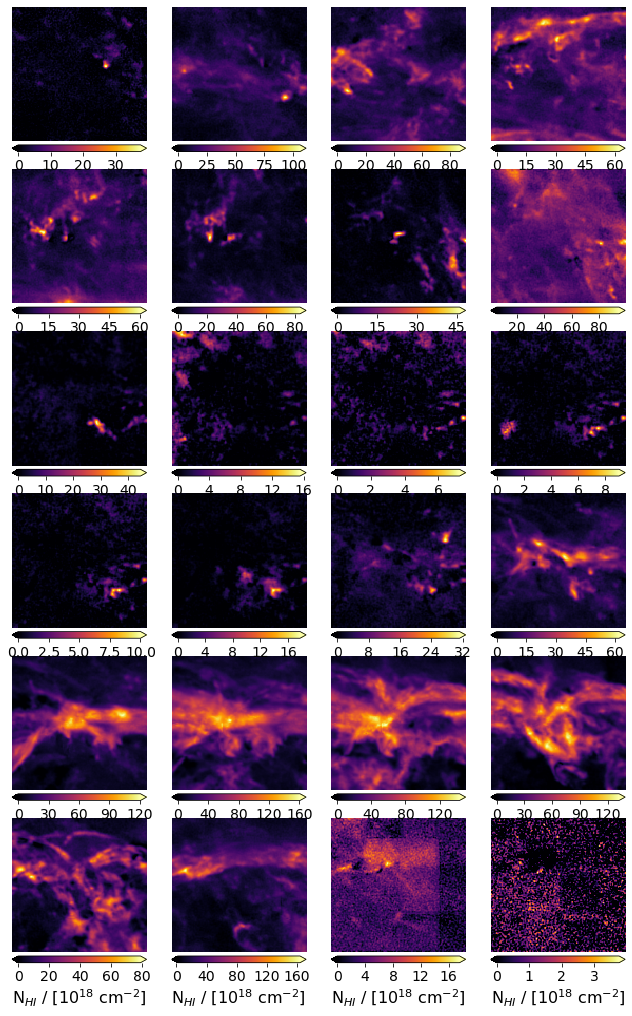

In [34]:
# Column Density
def cm2inch(*tupl):
        inch = 2.54
        if isinstance(tupl[0], tuple):
            return tuple(i/inch for i in tupl[0])
        else:
            return tuple(i/inch for i in tupl)
        
#Plot mosaic field  
fig=plt.figure()
lh = 6; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im = axs[i][j].imshow(field[k]/10**18, origin="lower", cmap="inferno")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"N$_{HI}$ / [10$^{18}$ cm$^{-2}$]", fontsize=16.)
        k += 1
print("Column Density maps")
fig.savefig("Column_Density_sub_spider.pdf", bbox_inches='tight')

Velocity maps


<Figure size 432x288 with 0 Axes>

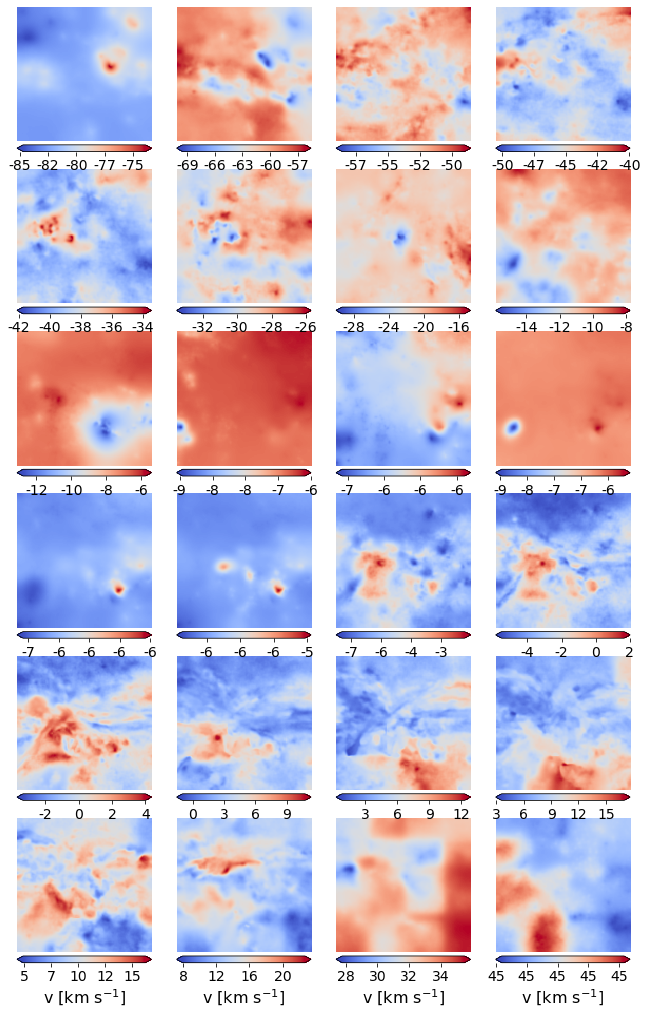

In [35]:
# Velocity 
fig=plt.figure()
lh = 6; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        elev_min=np.nanmin(vfield[k])
        elev_max=np.nanmax(vfield[k])
        mid_val=0
        im1 = axs[i][j].imshow(vfield[k], origin="lower", cmap="coolwarm")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%d', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"v [km s$^{-1}$]", fontsize=16.)
        k += 1
print("Velocity maps")
fig.savefig("Velocity_sub_spider.pdf", bbox_inches='tight')

Velocity Dispersion maps


<Figure size 432x288 with 0 Axes>

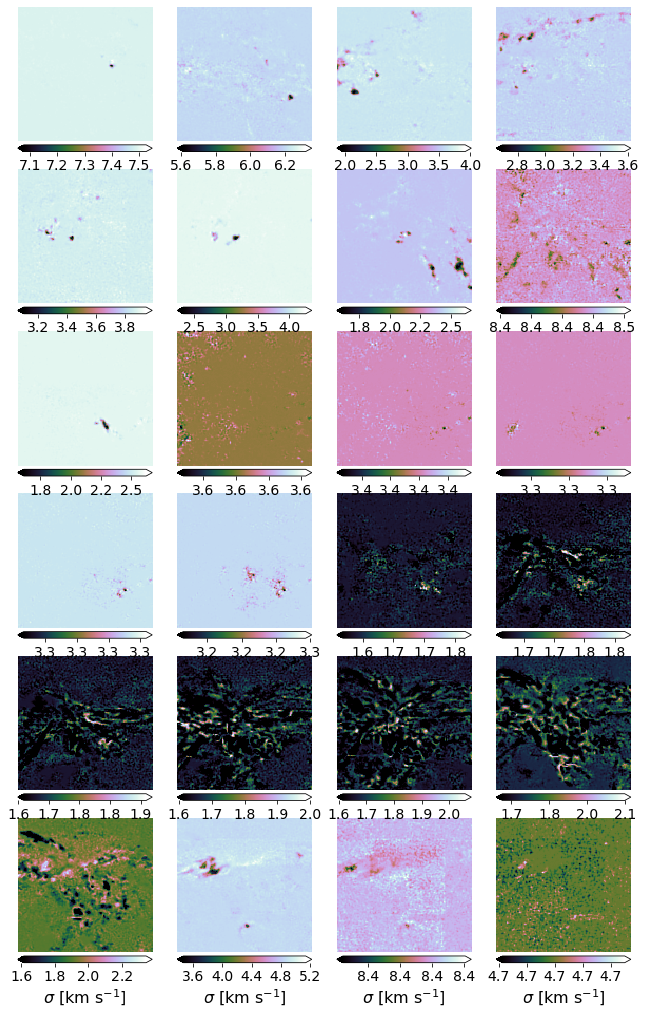

In [36]:
# Dispersion   
fig=plt.figure()
lh = 6; lw = 4
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im1 = axs[i][j].imshow(sigfield[k], origin="lower", cmap="cubehelix")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%.1f', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=16.)
        k += 1
print("Velocity Dispersion maps")
fig.savefig("Velocity_Dispersion_sub_spider.pdf", bbox_inches='tight')

## Plot a Residual Map

We saw earlier from the spectrum the fitted model and the data. According to the $\chi^{2}$ value, it was a good fit, but that was only one pixel position. This cube has 128x128 pixels. We can see just how good the model is for every pixel by producing a residual map. Ideally, it would be flat at zero.

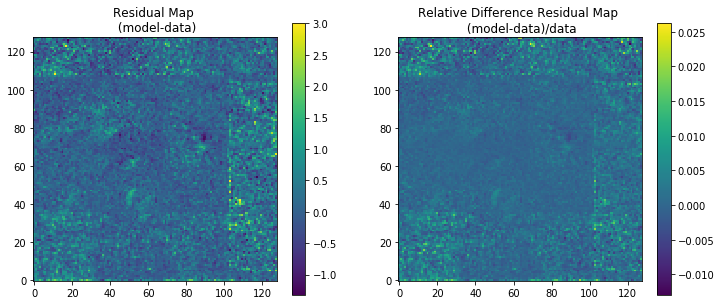

In [37]:
# Find the residual map
fig=plt.figure(figsize=(12,5))
mdl_sub_spider = np.sum(model_sub_spider[:400] , 0)
dat_sub_spider = np.sum(subcube_sub_spider[:400], 0)
res_sub_spider = (mdl_sub_spider - dat_sub_spider)

plt.subplot(1,2,1) ; plt.title("Residual Map \n (model-data)")
plt.imshow(res_sub_spider, origin="lower")
plt.colorbar()
plt.subplot(1,2,2) ; plt.title("Relative Difference Residual Map \n (model-data)/data")
plt.imshow(res_sub_spider/dat_sub_spider, origin="lower")
plt.colorbar()
fig.savefig("Residual_map_sub_spider.pdf", bbox_inches="tight")

I can plot a histogram of this residual to see how good the model is and fit a gaussian to it. For an ideal residual, we should see a gaussian shape for the histogram. The more Gaussian, the better.

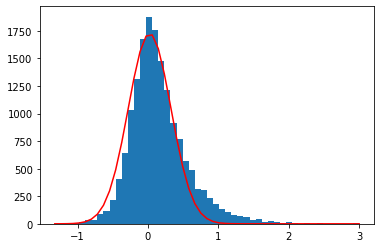

In [38]:
fig = plt.figure()
y_tot,x_tot,_ = plt.hist(res_sub_spider.ravel(), bins=50)
# Use scipy.curve_fit to get the gaussain fit for this histogram
#Guesses for the parameters:
amp_tot=3000.; cent_tot=0.2; sig_tot=1
popt, pcov = curve_fit(one_gauss_func, x_tot[:-1], y_tot, p0=[amp_tot,cent_tot,sig_tot])

plt.plot(x_tot, one_gauss_func(x_tot,*popt), 'r')
plt.show()
fig.savefig("Histogram_of_total_residual.pdf", bbox_inches="tight")

Can also look at the Standard Deviation Spectrum of the model cube and data cube.

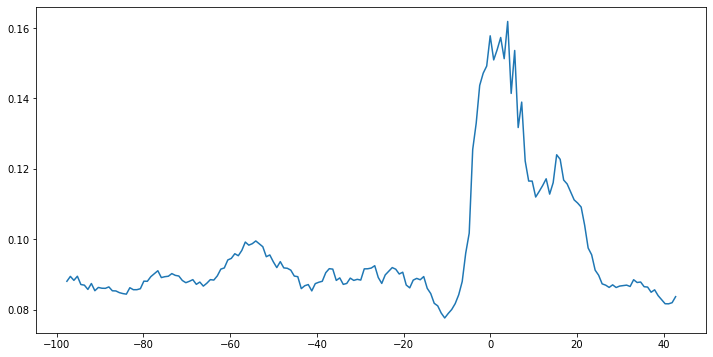

In [39]:
# Standard deviation spectrum
fig = plt.figure(figsize=(12,6))
plt.plot(fixed_subvel_sub_spider, np.std((model_sub_spider - subcube_sub_spider), (1,2)))
plt.show()
fig.savefig("Standard_Deviation_spectrum.pdf", bbox_inches='tight')

### Now can look at the Residual of LVC and IVC separately

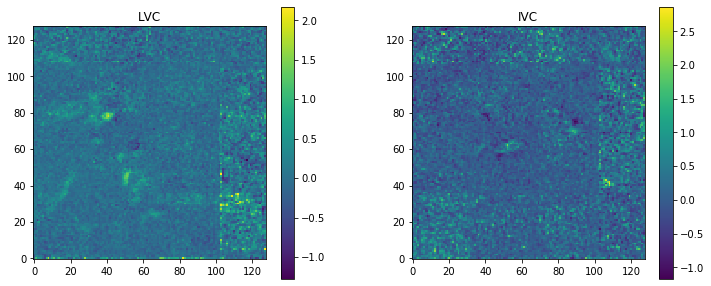

In [40]:
fig = plt.figure(figsize=(12,5))

mdl_LVC = np.sum(model_sub_spider[:90] , 0)
dat_LVC = np.sum(subcube_sub_spider[:90] , 0)
res_LVC = (mdl_LVC - dat_LVC)

mdl_IVC = np.sum(model_sub_spider[90:] , 0)
dat_IVC = np.sum(subcube_sub_spider[90:] , 0)
res_IVC = mdl_IVC - dat_IVC

plt.subplot(1,2,1) ; plt.title("LVC")
plt.imshow(res_LVC, origin="lower")
plt.colorbar()

plt.subplot(1,2,2) ; plt.title("IVC")
plt.imshow(res_IVC, origin="lower")
plt.colorbar()

plt.subplots_adjust(wspace=0.3); plt.show()
fig.savefig("Residual_maps_of_LVC_and_IVC.pdf", bbox_inches="tight")

I can also produce the histograms of these residual maps and fit a gaussian to them

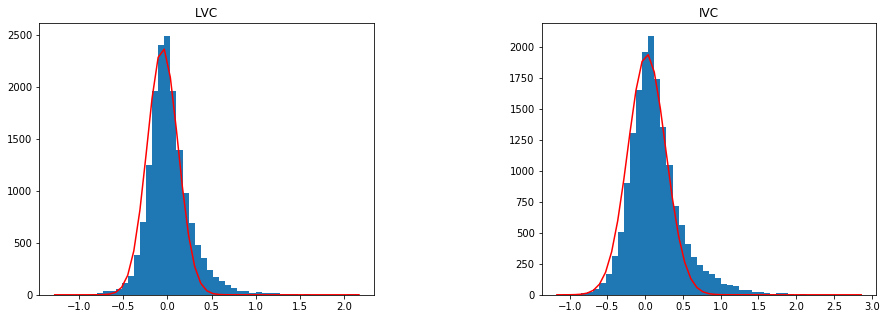

In [41]:
fig = plt.figure(figsize=(15,5))

# LVC
plt.subplot(1,2,1) ; plt.title("LVC")
y_LVC,x_LVC,_LVC = plt.hist(res_LVC.ravel(), bins=50)
amp_LVC=1800.; cent_LVC=0.3; sig_LVC = 2.
popt_LVC, pcov_LVC = curve_fit(one_gauss_func, x_LVC[:-1], y_LVC, p0=[amp_LVC,cent_LVC,sig_LVC])
plt.plot(x_LVC, one_gauss_func(x_LVC,*popt_LVC), 'r')

#IVC
plt.subplot(1,2,2) ; plt.title("IVC")
y_IVC,x_IVC,_IVC = plt.hist(res_IVC.ravel(), bins=50)
amp_IVC=1800.; cent_IVC=0.; sig_IVC = 2.
popt_IVC, pcov_IVC = curve_fit(one_gauss_func, x_IVC[:-1], y_IVC, p0=[amp_IVC,cent_IVC,sig_IVC])
plt.plot(x_IVC, one_gauss_func(x_IVC,*popt_IVC), 'r')

plt.subplots_adjust(wspace=0.5); plt.show()
fig.savefig("Histograms_of_Residuals_for_LVC_and_IVC.pdf", bbox_inches="tight")

## Write out to a fits file

Here, I am able to take a cube, either the models or the subcube, and write them to a fits file to be analyzed using a proper viewer.

In [42]:
# Updated new header with hopefully correct parameters

new_hdr = fits.Header()
new_hdr["CRPIX1"] = hdr["CRPIX1"] - 36
new_hdr["CRVAL1"] = hdr["CRVAL1"]
new_hdr["CDELT1"] = hdr["CDELT1"]
new_hdr["CTYPE1"] = hdr["CTYPE1"]

new_hdr["CRPIX2"] = hdr["CRPIX2"] - 32
new_hdr["CRVAL2"] = hdr["CRVAL2"]
new_hdr["CDELT2"] = hdr["CDELT2"]
new_hdr["CTYPE2"] = hdr["CTYPE2"]

new_hdr["CRPIX3"] = 0
new_hdr["CRVAL3"] = fixed_subvel_sub_spider[0]
new_hdr["CDELT3"] = hdr["CDELT3"] / 1000. # In km/s
new_hdr["CTYPE3"] = hdr["CTYPE3"] # 'FELO-LSR'

new_hdr["BUNIT"] = hdr["BUNIT"] # 'K'

empty_primary = fits.PrimaryHDU(model_LVC_CNM, header=new_hdr)

hdulist = fits.HDUList([empty_primary])
#hdulist.writeto("sub_spider_LVC_CNM_lambda_100_varsig_150.fits", clobber=True)